In [1]:
import sys

sys.path.append("..")
from omegaconf import OmegaConf
from sgm.util import instantiate_from_config

config = OmegaConf.load(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/configs/inference/sd_1_5.yaml"
)
print(config)
config["model"]["params"][
    "ckpt_path"
] = "/vol/paramonos2/projects/antoni/code/Personal/generative-models/checkpoints/leosamsFilmgirlUltra_ultraBaseModel_renamed.safetensors"
# config["model"]["params"]["network_config"]["params"]["fine_tuning_method"] = None
model = instantiate_from_config(config.model)
model = model.to("cuda")

/vol/paramonos2/projects/antoni/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'model': {'target': 'sgm.models.diffusion.DiffusionEngine', 'params': {'scale_factor': 0.18215, 'separate_unet_ckpt': '../checkpoints/unet_1_5.pt', 'disable_first_stage_autocast': True, 'denoiser_config': {'target': 'sgm.modules.diffusionmodules.denoiser.DiscreteDenoiser', 'params': {'num_idx': 1000, 'scaling_config': {'target': 'sgm.modules.diffusionmodules.denoiser_scaling.EpsScaling'}, 'discretization_config': {'target': 'sgm.modules.diffusionmodules.discretizer.LegacyDDPMDiscretization'}}}, 'network_wrapper': {'target': 'sgm.modules.diffusionmodules.wrappers.StabilityWrapper', 'params': {'use_ipadapter': True, 'ipadapter_model': 'ip-adapter_sd15.bin', 'adapter_scale': 1.0, 'n_adapters': 1, 'skip_text_emb': False}}, 'network_config': {'target': 'sgm.modules.diffusionmodules.diffuser_unet.UNet2DConditionModel', 'params': {'in_channels': 4, 'act_fn': 'silu', 'attention_head_dim': 8, 'block_out_channels': [320, 640, 1280, 1280], 'center_input_sample': False, 'cross_attention_dim': 768

In [ ]:
for p in model.model.diffusion_model.parameters():
    p.requires_grad = False

In [ ]:
from diffusers.models.attention_processor import IPAdapterAttnProcessor2_0

for att_layer in model.model.diffusion_model.attn_processors.values():
    if isinstance(att_layer, IPAdapterAttnProcessor2_0):
        for p in att_layer.parameters():
            p.requires_grad = True

In [ ]:
for name, p in model.model.diffusion_model.named_parameters():
    if p.requires_grad:
        print(name)

In [ ]:
import torch

adapter_cross = torch.nn.ModuleList(model.model.diffusion_model.attn_processors.values())
for p in adapter_cross.parameters():
    p.requires_grad = False

In [ ]:
for module in model.model.diffusion_model.attn_processors.values():
    for param in module.parameters():
        param.requires_grad = False

In [ ]:
from safetensors.torch import load_file

ckpt = load_file(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/checkpoints/v1-5-pruned-emaonly.safetensors"
)
ckpt.keys()

In [ ]:
from diffusers.utils import _get_model_file
from diffusers.models.modeling_utils import load_state_dict

model_file = _get_model_file(
    "h94/IP-Adapter",
    weights_name="ip-adapter_sd15.bin",
    cache_dir="/vol/paramonos2/projects/antoni/.cache",
    subfolder="models",
)
state_dict = load_state_dict(model_file)

In [ ]:
from diffusers.models.attention_processor import IPAdapterAttnProcessor, IPAdapterAttnProcessor2_0

unet = model.model.diffusion_model
scale = 0.5
for attn_processor in unet.attn_processors.values():
    if isinstance(attn_processor, (IPAdapterAttnProcessor, IPAdapterAttnProcessor2_0)):
        if not isinstance(scale, list):
            scale = [scale] * len(attn_processor.scale)
        if len(attn_processor.scale) != len(scale):
            raise ValueError(
                f"`scale` should be a list of same length as the number if ip-adapters "
                f"Expected {len(attn_processor.scale)} but got {len(scale)}."
            )
        print(f"Setting scale to {scale}")
        print(f"Old scale: {attn_processor.scale}")
        attn_processor.scale = scale

In [ ]:
model.model.diffusion_model._load_ip_adapter_weights(state_dict)

In [ ]:
from transformers import CLIPVisionModelWithProjection

image_encoder = CLIPVisionModelWithProjection.from_pretrained("h94/IP-Adapter", subfolder="models/image_encoder")
image_encoder

In [ ]:
model.model.diffusion_model.load_state_dict(state_dict)

In [2]:
from transformers import AutoProcessor, CLIPVisionModel

processor = AutoProcessor.from_pretrained("openai/clip-vit-large-patch14")
# model = CLIPVisionModel.from_pretrained("openai/clip-vit-large-patch14")
# model = CLIPVisionTransformer.from_pretrained("openai/clip-vit-large-patch14")

In [ ]:
import torch
import open_clip

arch = "ViT-H-14"
version = "laion2b_s32b_b79k"
model_open, _, _ = open_clip.create_model_and_transforms(
    arch,
    device="cuda",
    pretrained=version,
    cache_dir="/vol/paramonos2/projects/antoni/.cache",
)

In [3]:
from PIL import Image
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
url = "/vol/paramonos2/projects/antoni/code/Personal/generative-models/notebooks/pic1.png"
image = Image.open(url)
# image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(images=image, return_tensors="pt")

# out = image_encoder(inputs.pixel_values)

# out.image_embeds.shape, out.last_hidden_state.shape

In [9]:
inputs["pixel_values"].max(), inputs["pixel_values"].min()

(tensor(1.5362), tensor(-1.7923))

In [ ]:
x = model_open.visual(inputs.pixel_values.to("cuda")).shape
x

In [ ]:
model.get_input_embeddings()

In [ ]:
out.last_hidden_state.mean(1) == out.pooler_output

In [5]:
import torch

batch = {}
batch["txt"] = [" bite "]
batch["img"] = inputs.pixel_values.to("cuda")
batch_uc = batch.copy()
for key in batch.keys():
    if key not in batch_uc and isinstance(batch[key], torch.Tensor):
        batch_uc[key] = torch.clone(batch[key])

c, uc = model.conditioner.get_unconditional_conditioning(
    batch,
    batch_uc=batch_uc,
    force_uc_zero_embeddings=["txt", "img"],
)
c, uc

({'crossattn': tensor([[[-0.3843,  0.0214, -0.0568,  ..., -0.4878, -0.3037,  0.0652],
           [-0.1435, -1.2046, -0.2601,  ...,  0.8885, -0.1983, -0.9110],
           [-0.1937, -1.1417, -0.1986,  ...,  1.0383, -0.3851, -0.8202],
           ...,
           [ 1.6483, -0.3241, -0.4664,  ...,  1.0203, -2.0462,  0.1775],
           [ 1.6477, -0.3054, -0.4687,  ...,  1.0461, -2.0656,  0.1821],
           [ 1.6828, -0.3017, -0.4470,  ...,  1.0029, -1.9689,  0.1220]]],
         device='cuda:0'),
  'image_embeds': tensor([[[ 0.4590,  0.2070,  0.1202,  ...,  0.4680, -0.1421,  0.3928]]],
         device='cuda:0')},
 {'crossattn': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'),
  'image_embeds': tensor([[[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')}

In [16]:
torch.save(c["crossattn"], "../checkpoints/null_txt.pt")

In [7]:
c["crossattn"] = uc["crossattn"]

In [6]:
sampler_config = {}
sampler_config["target"] = "sgm.modules.diffusionmodules.sampling.EulerEDMSampler"
sampler_config["params"] = {
    "num_steps": 30,
    "discretization_config": {"target": "sgm.modules.diffusionmodules.discretizer.LegacyDDPMDiscretization"},
    "guider_config": {"target": "sgm.modules.diffusionmodules.guiders.IdentityGuider", "params": {"scale": 1.4}},
}

model.sampler = instantiate_from_config(sampler_config)

In [ ]:
model.model.diffusion_model.set_ip_adapter_scale(0.5)

Num steps:  30
##############################  Sampling setting  ##############################
Sampler: EulerEDMSampler
Discretization: LegacyDDPMDiscretization
Guider: IdentityGuider


Sampling with EulerEDMSampler for 31 steps:   0%|          | 0/31 [00:00<?, ?it/s]

Sampling with EulerEDMSampler for 31 steps:  97%|█████████▋| 30/31 [00:02<00:00, 10.78it/s]


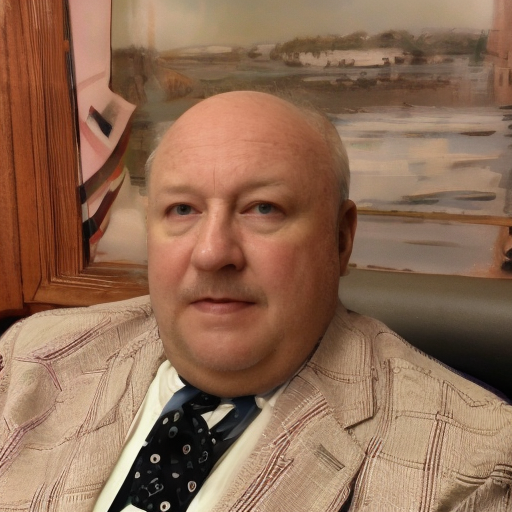

: 

In [8]:
model = model.to("cuda")
samples = model.sample(c, shape=(4, 512 // 8, 512 // 8), uc=uc, batch_size=1)
samples = model.decode_first_stage(samples)
sample_pil = (((samples + 1) / 2).clamp(0, 1) * 255.0).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()[0]
from PIL import Image

Image.fromarray(sample_pil).show()

In [ ]:
setattr(model.model.diffusion_model, "config", {})

In [ ]:
setattr(model.model.diffusion_model, "dtype", torch.float32)

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

pipeline_1_5 = StableDiffusionPipeline.from_single_file(
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/checkpoints/leosamsFilmgirlUltra_ultraBaseModel_renamed.safetensors",
    #    unet=model.model.diffusion_model
)
pipeline_2_1 = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    # torch_dtype=torch.float16,
    cache_dir="/vol/paramonos2/projects/antoni/.cache",
)
pipeline_1_5 = pipeline_1_5.to("cuda")

In [ ]:
pipeline_1_5.load_ip_adapter("h94/IP-Adapter", subfolder="models", weight_name="ip-adapter-full-face_sd15.bin")

In [ ]:
pipeline_1_5.unet.attn_processors

In [ ]:
from diffusers.models.attention_processor import AttnProcessor, IPAdapterAttnProcessor2_0

unet = pipeline_1_5.unet
unet_sd = unet.state_dict()
attn_procs = {}
for name in unet.attn_processors.keys():
    cross_attention_dim = None if name.endswith("attn1.processor") else unet.config.cross_attention_dim
    if name.startswith("mid_block"):
        hidden_size = unet.config.block_out_channels[-1]
    elif name.startswith("up_blocks"):
        block_id = int(name[len("up_blocks.")])
        hidden_size = list(reversed(unet.config.block_out_channels))[block_id]
    elif name.startswith("down_blocks"):
        block_id = int(name[len("down_blocks.")])
        hidden_size = unet.config.block_out_channels[block_id]
    if cross_attention_dim is None:
        attn_procs[name] = AttnProcessor()
    else:
        layer_name = name.split(".processor")[0]
        weights = {
            "to_k_ip.weight": unet_sd[layer_name + ".to_k.weight"],
            "to_v_ip.weight": unet_sd[layer_name + ".to_v.weight"],
        }
        attn_procs[name] = IPAdapterAttnProcessor2_0(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)
        attn_procs[name].load_state_dict(weights)
# unet.set_attn_processor(attn_procs)
attn_procs

In [ ]:
torch.save(
    {"state_dict": state_dict},
    "/vol/paramonos2/projects/antoni/code/Personal/generative-models/checkpoints/unet_1_5.pt",
)

In [ ]:
import math
from einops import repeat


def timestep_embedding(timesteps, dim, max_period=10000, repeat_only=False):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    if not repeat_only:
        half = dim // 2
        freqs = torch.exp(-math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half).to(
            device=timesteps.device
        )
        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    else:
        embedding = repeat(timesteps, "b -> b d", d=dim)
    return embedding


openai_time = timestep_embedding(torch.arange(0, 30).float(), 64, repeat_only=False)

In [ ]:
def get_timestep_embedding(
    timesteps: torch.Tensor,
    embedding_dim: int,
    flip_sin_to_cos: bool = False,
    downscale_freq_shift: float = 1,
    scale: float = 1,
    max_period: int = 10000,
):
    """
    This matches the implementation in Denoising Diffusion Probabilistic Models: Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param embedding_dim: the dimension of the output. :param max_period: controls the minimum frequency of the
    embeddings. :return: an [N x dim] Tensor of positional embeddings.
    """
    assert len(timesteps.shape) == 1, "Timesteps should be a 1d-array"

    half_dim = embedding_dim // 2
    exponent = -math.log(max_period) * torch.arange(
        start=0, end=half_dim, dtype=torch.float32, device=timesteps.device
    )
    exponent = exponent / (half_dim - downscale_freq_shift)

    emb = torch.exp(exponent)
    emb = timesteps[:, None].float() * emb[None, :]

    # scale embeddings
    emb = scale * emb

    # concat sine and cosine embeddings
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

    # flip sine and cosine embeddings
    if flip_sin_to_cos:
        emb = torch.cat([emb[:, half_dim:], emb[:, :half_dim]], dim=-1)

    # zero pad
    if embedding_dim % 2 == 1:
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb


sd_time = get_timestep_embedding(torch.arange(0, 30).float(), 64, flip_sin_to_cos=True, downscale_freq_shift=0)

In [ ]:
from sgm.util import get_obj_from_str

# wrapper_config = {"target"}
model_stability = get_obj_from_str("sgm.modules.diffusionmodules.wrappers.StabilityWrapper")(pipeline_1_5.unet)

In [ ]:
to_check = ["feature_extractor", "scheduler", "text_encoder", "tokenizer", "unet", "vae"]
for attr in to_check:
    print("-" * 50)
    print(attr)
    attribute_obj = getattr(pipeline_1_5, attr)
    attribute_obj_2_1 = getattr(pipeline_2_1, attr)
    if attribute_obj is not None:
        if hasattr(attribute_obj, "config"):
            print(attribute_obj.config)

    if attribute_obj_2_1 is not None:
        if hasattr(attribute_obj_2_1, "config"):
            print(attribute_obj_2_1.config)
            print(attribute_obj_2_1.config == attribute_obj.config)

    print("-" * 50)

In [ ]:
for key in pipeline_2_1.config:
    print(pipeline_2_1.config[key])
    for key in pipeline_2_1.config[key][1].config:
        print(key)

In [ ]:
from diffusers import EulerAncestralDiscreteScheduler, EulerDiscreteScheduler

pipeline_1_5.scheduler = EulerDiscreteScheduler.from_config(pipeline_1_5.scheduler.config)

In [ ]:
generator = torch.Generator(device="cpu").manual_seed(42)

image = pipeline_1_5(
    prompt="a photo portrait of a person",
    # ip_adapter_image=image,
    # prompt_embeds=prompt_emb,
    generator=generator,
    negative_prompt="",
    num_inference_steps=30,
    guidance_scale=1.0,
    num_images_per_prompt=10,
    height=512,
    width=512,
).images[0]
image

In [ ]:
from diffusers.utils import load_image

im_input = load_image("/vol/paramonos2/projects/antoni/code/Personal/Old/generating_laugh/bigata_antoni_cropped.png")
im_input = pipeline_1_5.feature_extractor(im_input, return_tensors="pt").pixel_values
out_1 = pipeline_1_5.vae.encode(im_input.to("cuda")).latent_dist.sample() * pipeline_1_5.vae.config.scaling_factor
out_2 = pipeline_2_1.vae.encode(im_input).latent_dist.sample() * pipeline_2_1.vae.config.scaling_factor

In [ ]:
decoded_1 = pipeline_1_5.vae.decode(samples.cuda() / pipeline_1_5.vae.config.scaling_factor).sample
decoded_2 = pipeline_2_1.vae.decode(samples.cpu() / pipeline_2_1.vae.config.scaling_factor).sample

In [ ]:
# Show decoded images
from PIL import Image
import torchvision.transforms as T


def to_pil_image(tensor):
    return T.ToPILImage()(((tensor + 1) / 2).clamp(0, 1))


to_pil_image(decoded_1.cpu().detach().squeeze(0))

In [ ]:
to_pil_image(decoded_2.cpu().detach().squeeze(0))

In [ ]:
torch.isclose(out_1.cpu(), out_2, atol=1e-1).all()

In [ ]:
import torch
import thunder


def foo(a, b):
    return a + b


jfoo = thunder.jit(foo)

a = torch.full((2, 2), 1)
b = torch.full((2, 2), 3)

result = jfoo(a, b)

print(result)

# prints
# tensor(
#  [[4, 4]
#   [4, 4]])